# Connect and authorize google drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
!ls

In [ ]:
%cd /content/gdrive/My Drive/Colab Notebooks/ML_HI/tano_signal/
!ls

In [ ]:
! pwd

# Install

In [ ]:
! pip install spectral_cube

# Libraries

In [104]:
import sys
import os
import copy

import numpy as np
import pandas as pd

from astropy.io  import fits
from astropy        import units as u
from astropy.wcs import WCS

from scipy.stats import gaussian_kde
from sklearn.metrics import mean_squared_error

import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import seaborn as sns

from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from pathlib import Path

from spectral_cube import SpectralCube

In [105]:
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'

# GPU or CPU

In [106]:
# GPU or CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device: ', device)
print('device_count: ', torch.cuda.device_count())

device:  cpu
device_count:  0


# Paths

In [107]:
base_path = Path('/content/gdrive/MyDrive/Colab Notebooks/ML/')

tano_signal_path = base_path / 'tano_signal' / 'tano_signal'
checkpoint_path  = tano_signal_path / 'checkpoints'
ct256_checkpoint_path = checkpoint_path / 'c256'

data_path     = base_path / 'data'
uma_data_path = data_path / 'UMA'

tanosignal_path      = base_path / 'tano_signal'
tanosignal_pred_path = tanosignal_path / 'pred'

saury2014_data_path = data_path / 'saury'
seta222_data_path   = data_path / 'seta'

# Utils

In [108]:
def read_fits_cube(filename):
    """
    Read

    Parameters
    ----------
    filename (string) : filename of FITS file
    Input data.

    Returns
    -------
    cube
    WCS
    X-coordinates
    Y-coordinates
    Velocity

    Other parameters
    ----------------
    None
    """

    # Read FITS file
    dat = fits.open(filename)  # Open the FITS file for reading
    c = SpectralCube.read(dat)  # Initiate a SpectralCube

    # Parse the WCS keywords in the primary HDU
    hdr = dat[0].header

    w = WCS(naxis=2)
    w.wcs.crpix = [hdr['CRPIX1'], hdr['CRPIX2']]
    w.wcs.cdelt = np.array([hdr['CDELT1'], hdr['CDELT2']])
    w.wcs.crval = [hdr['CRVAL1'], hdr['CRVAL2']]
    w.wcs.ctype = [hdr['CTYPE1'], hdr['CTYPE2']]

    dat.close()

    print(f"Cube shape: {c.shape}") # (vlsr, b, l)

    del dat

    _, _, x = c.world[0, 0, :]      # extract RA: deg
    _, y, _ = c.world[0, :, 0]      # extract DEC:  deg
    v, _, _ = c.world[:, 0, 0]      # extract velocity

    return c, w, x, y, v, hdr

In [109]:
def get_val_pix(datmap, x, y, w):
    # Convert world coordinates to pixel coordinates
    xpix, ypix = w.world_to_pixel_values(x, y)

    # Round pixel coordinates to nearest integer
    xpix = [int(round(xi)) for xi in xpix]
    ypix = [int(round(yi)) for yi in ypix]

    # Access data array using the computed pixel coordinates
    value = datmap[ypix, xpix]

    return value, xpix, ypix

# Read data

In [ ]:
# Training and test datasets
training_data_file_q0 = 'Tb_n01_pw02_vs12_512_thick_256chan_quarter_0_noise_1.0_K_beam_1.45_pix.fits'
training_data_file_q1 = 'Tb_n01_pw02_vs12_512_thick_256chan_quarter_1_noise_1.0_K_beam_1.45_pix.fits'
training_data_file_q2 = 'Tb_n01_pw02_vs12_512_thick_256chan_quarter_2_noise_1.0_K_beam_1.45_pix.fits'
training_data_file_q3 = 'Tb_n01_pw02_vs12_512_thick_256chan_quarter_3_noise_1.0_K_beam_1.45_pix.fits'

training_data_file_q0 = saury2014_data_path / training_data_file_q0
training_data_file_q1 = saury2014_data_path / training_data_file_q1
training_data_file_q2 = saury2014_data_path / training_data_file_q2
training_data_file_q3 = saury2014_data_path / training_data_file_q3

# HI optical depth
tau_data_file_q0 = 'tau_n01_pw02_vs12_512_thick_256chan_quarter_0_noise_beam_1.45_pix.fits'
tau_data_file_q1 = 'tau_n01_pw02_vs12_512_thick_256chan_quarter_1_noise_beam_1.45_pix.fits'
tau_data_file_q2 = 'tau_n01_pw02_vs12_512_thick_256chan_quarter_2_noise_beam_1.45_pix.fits'
tau_data_file_q3 = 'tau_n01_pw02_vs12_512_thick_256chan_quarter_3_noise_beam_1.45_pix.fits'

tau_data_file_q0 = saury2014_data_path / tau_data_file_q0
tau_data_file_q1 = saury2014_data_path / tau_data_file_q1
tau_data_file_q2 = saury2014_data_path / tau_data_file_q2
tau_data_file_q3 = saury2014_data_path / tau_data_file_q3


# 2a. R_HI maps
rhi_file_q0 = 'R_map_n01_pw02_vs12_512px_quarter_0_noise.fits'
rhi_file_q1 = 'R_map_n01_pw02_vs12_512px_quarter_1_noise.fits'
rhi_file_q2 = 'R_map_n01_pw02_vs12_512px_quarter_2_noise.fits'
rhi_file_q3 = 'R_map_n01_pw02_vs12_512px_quarter_3_noise.fits'

rhi_file_q0 = saury2014_data_path / rhi_file_q0
rhi_file_q1 = saury2014_data_path / rhi_file_q1
rhi_file_q2 = saury2014_data_path / rhi_file_q2
rhi_file_q3 = saury2014_data_path / rhi_file_q3

# 3a. FCNM maps with noise
fcnm_file_q0 = 'fcnm_map_n01_pw02_vs12_Tcut_500K_512px_quarter_0_noise.fits'
fcnm_file_q1 = 'fcnm_map_n01_pw02_vs12_Tcut_500K_512px_quarter_1_noise.fits'
fcnm_file_q2 = 'fcnm_map_n01_pw02_vs12_Tcut_500K_512px_quarter_2_noise.fits'
fcnm_file_q3 = 'fcnm_map_n01_pw02_vs12_Tcut_500K_512px_quarter_3_noise.fits'

fcnm_file_q0 = saury2014_data_path / fcnm_file_q0
fcnm_file_q1 = saury2014_data_path / fcnm_file_q1
fcnm_file_q2 = saury2014_data_path / fcnm_file_q2
fcnm_file_q3 = saury2014_data_path / fcnm_file_q3

print(training_data_file_q0)
print(fcnm_file_q0)
print(rhi_file_q0)

# UMA data cube:
# Spectal res: 1.32 km/s
# Channel spacing: 0.824 km/s

In [111]:
training_data_file_q4 = 'Tb_mpism_comp_1200_thick_256chan_noise_1.0_K_beam_1.45_pix.fits'
training_data_file_q4 = seta222_data_path / training_data_file_q4

tau_data_file_q4 = 'tau_mpism_comp_1200_thick_256chan_noise_beam_1.45_pix.fits'
tau_data_file_q4 = seta222_data_path / tau_data_file_q4

rhi_file_q4 = 'rhi_map_mpism_comp_1200_Tcut_500K_thick_256chan.fits'
rhi_file_q4 = seta222_data_path / rhi_file_q4

fcnm_file_q4 = 'fcnm_map_mpism_comp_1200_Tcut_500K_thick_256chan.fits'
fcnm_file_q4 = seta222_data_path / fcnm_file_q4



training_data_file_q4 = 'Tb_mpism_sol_800_thick_256chan_noise_1.0_K_beam_1.45_pix.fits'
training_data_file_q4 = seta222_data_path / training_data_file_q4

tau_data_file_q4 = 'tau_mpism_sol_800_turb_thick_256chan_noise.fits'
tau_data_file_q4 = seta222_data_path / tau_data_file_q4

rhi_file_q4 = 'rhi_map_mpism_sol_800_Tcut_500K_thick_101chan.fits'
rhi_file_q4 = seta222_data_path / rhi_file_q4

fcnm_file_q4 = 'fcnm_map_mpism_sol_800_Tcut_500K.fits'
fcnm_file_q4 = seta222_data_path / fcnm_file_q4

In [112]:
dv = 0.3125 # km/s
print('dv:', dv)

dv: 0.3125


In [113]:
cube, header1 = fits.getdata(training_data_file_q4, header=True)
taucube, thdr1 = fits.getdata(tau_data_file_q4, header=True)
taucube = taucube[:256, :, :]
#
fcnm_data, header1 = fits.getdata(fcnm_file_q4, header=True)
#
rhi_data, header1 = fits.getdata(rhi_file_q4, header=True)

In [114]:
nlen = 512*512*3
nclen = 512*512

NHI_flat = np.zeros(nlen)
TPEAK_flat = np.zeros(nlen)
EW_flat = np.zeros(nlen)
TAU_flat = np.zeros(nlen)
FCNM_flat = np.zeros(nlen)
RHI_flat = np.zeros(nlen)

In [ ]:
cfiles = [training_data_file_q0, training_data_file_q1, training_data_file_q2, training_data_file_q4]
tfiles = [tau_data_file_q0, tau_data_file_q1, tau_data_file_q2, tau_data_file_q4]
ffiles = [fcnm_file_q0, fcnm_file_q1, fcnm_file_q2, fcnm_file_q4]
rfiles = [rhi_file_q0, rhi_file_q1, rhi_file_q2, rhi_file_q4]


cfiles = [training_data_file_q0, training_data_file_q3, training_data_file_q4]
tfiles = [tau_data_file_q0, tau_data_file_q3, tau_data_file_q4]
ffiles = [fcnm_file_q0, fcnm_file_q3, fcnm_file_q4]
rfiles = [rhi_file_q0, rhi_file_q3, rhi_file_q4]
for i in range(3):
  print(cfiles[i], tfiles[i], ffiles[i], rfiles[i])

  cube, header1 = fits.getdata(cfiles[i], header=True)
  taucube, thdr1 = fits.getdata(tfiles[i], header=True)
  taucube = taucube[:256, :, :]
  fcnm_data, header1 = fits.getdata(ffiles[i], header=True)
  rhi_data, header1 = fits.getdata(rfiles[i], header=True)

  # TB max
  tbmax_map = np.max(cube, axis=0)
  tbmax_flat = tbmax_map.flatten()

  Fcnm_gt_flat = fcnm_data.flatten()


  WHI = np.sum(cube, axis=0)
  NHI_thin = 1.8224 * 1.e-2 * WHI * dv # In unit of 10^20 cm-2
  NHI_thin_flat = NHI_thin.flatten()

  taumax = np.max(taucube, axis=0)
  taumax_flat = taumax.flatten()
  ew = np.sum(taucube, axis=0) * dv
  ew_flat = ew.flatten()

  NHI_flat[i*nclen : (i+1)*nclen] = NHI_thin_flat
  TPEAK_flat[i*nclen : (i+1)*nclen] = tbmax_flat
  EW_flat[i*nclen : (i+1)*nclen] = ew_flat
  TAU_flat[i*nclen : (i+1)*nclen] = taumax_flat
  FCNM_flat[i*nclen : (i+1)*nclen] = Fcnm_gt_flat
  RHI_flat[i*nclen : (i+1)*nclen] = rhi_data.flatten()

In [116]:
taucube.shape

(256, 512, 512)

In [117]:
nchan, ny, nx = cube.shape
print(nchan, ny, nx)

256 512 512


In [118]:
cube1, header1      = fits.getdata(training_data_file_q0, header=True)
fcnm_data1, header1 = fits.getdata(fcnm_file_q0, header=True)
rhi_data1, header1  = fits.getdata(rhi_file_q0, header=True)

# Validation data cube

In [119]:
# Training and test datasets
# 1. Datacubes: 04 datacubes with size of (512 x 512 x Nchan)
training_data_file_q3 = 'Tb_n01_pw02_vs12_512_thick_256chan_quarter_3_noise_1.0_K_beam_1.45_pix.fits'
training_data_file_q3 = saury2014_data_path / training_data_file_q3

# HI optical depth
tau_data_file_q3 = 'tau_n01_pw02_vs12_512_thick_256chan_quarter_3_noise_beam_1.45_pix.fits'
tau_data_file_q3 = saury2014_data_path / tau_data_file_q3


# 2a. R_HI maps
rhi_file_q3 = 'R_map_n01_pw02_vs12_512px_quarter_3_noise.fits'
rhi_file_q3 = saury2014_data_path / rhi_file_q3

# 3a. FCNM maps with noise
fcnm_file_q3 = 'fcnm_map_n01_pw02_vs12_Tcut_500K_512px_quarter_3_noise.fits'
fcnm_file_q3 = saury2014_data_path / fcnm_file_q3


cube, header1 = fits.getdata(training_data_file_q3, header=True)
taucube, thdr1 = fits.getdata(tau_data_file_q3, header=True)
taucube = taucube[:256, :, :]
fcnm_data, header1 = fits.getdata(fcnm_file_q3, header=True)
rhi_data, header1 = fits.getdata(rhi_file_q3, header=True)

# TB max
tbmax_map = np.max(cube, axis=0)
tbmax_flat = tbmax_map.flatten()

Fcnm_gt_flat = fcnm_data.flatten()
rhi_data_gt_flat = rhi_data.flatten()

# Sum along 101 velocity channels
dvtb = 0.3125 # km/s
print('dv:', dvtb)
WHI = np.sum(cube, axis=0)
NHI_thin = 1.8224 * 1.e-2 * WHI * dvtb # In unit of 10^20 cm-2
NHI_thin_flat = NHI_thin.flatten()

dvtau = 0.3125 # km/s
taumax = np.max(taucube, axis=0)
taumax_flat = taumax.flatten()
ew = np.sum(taucube, axis=0) * dvtau
ew_flat = ew.flatten()

dv: 0.3125


In [120]:
nchan, ny, nx = cube.shape
print(nchan, ny, nx)

256 512 512


In [121]:
num = ny*nx
num

262144

# CNN-Transformer model

In [ ]:
# CNN-Transformer model
pe_list = ['original_vector', 'index_add', 'index_concate', 'poly_concate', 'sin_add', 'sin_concate']

pev = 'sin_add'
input_column = 256 # number of velocity channels
num_output   = 2
dropout      = 0.

# Model
cnn_trans = models.CNN_Transformer(pev, num_output, input_column, dropout, device)

# Load weights
weight_cp_file = ct256_checkpoint_path / f'ctrans_{pev}_10_{input_column}_final.pth'
cnn_trans.load_weights(weight_cp_file)

In [124]:
if False:
  fcnm, rhi = cnn_trans.predict(cube)
  np.savez(tanosignal_pred_path / 'saury' / f'ctrans_{pev}_fcnm_rhi.npz', x=fcnm, y=rhi)

In [126]:
temp_data = np.load(tanosignal_pred_path / 'saury' / f'ctrans_{pev}_fcnm_rhi.npz')
fcnm = temp_data['x']
rhi = temp_data['y']
temp_data.close()
del temp_data

# Predictions

In [ ]:
saury_pred_path = tanosignal_pred_path / 'saury'
print(saury_pred_path)

In [128]:
pev = 'sin_add'
npzdata = np.load(saury_pred_path / f'ctrans_{pev}_fcnm_rhi.npz')
fcnm    = npzdata['x']
rhi     = npzdata['y']
npzdata.close()

In [129]:
nx, ny = fcnm.shape
print(nx, ny)

512 512


# $F_{CNM}$

In [130]:
Fcnm_gt_flat = fcnm_data.flatten()
NHI_thin_flat = NHI_thin.flatten()

In [131]:
print(np.min(fcnm))
print(np.median(fcnm))
print(np.max(fcnm))

0.0
0.0036575719714164734
0.9023244380950928


In [132]:
Fcnm_flat = fcnm.flatten()

In [133]:
y_pred_0 = np.squeeze(fcnm).copy()
y_gt_0 = np.squeeze(fcnm_data).copy()

y_pred = np.squeeze(fcnm).copy()
y_gt = np.squeeze(fcnm_data).copy()

thresh = 0.02
y_gt[y_gt < thresh] = thresh
y_pred[y_pred < thresh] = thresh

fcnm_diff = y_gt - y_pred
fcnm_diff = 100*(fcnm_diff / y_gt)

fcnm_diff[np.isnan(fcnm_diff)] = 0.
fcnm_diff[np.isinf(fcnm_diff)] = 0.
fcnm_diff[fcnm_diff < -fcnm_diff.max()] = -fcnm_diff.max()

fcnm_mse = mean_squared_error(y_gt, y_pred)
print(fcnm_mse, np.sqrt(fcnm_mse))


y_pred_flat = y_pred.flatten()
y_gt_flat   = y_gt.flatten()

0.001092335746587941 0.03305050297027174


In [134]:
print( np.mean(np.abs(fcnm_diff)), np.median(np.abs(fcnm_diff)), np.std(np.abs(fcnm_diff)))

11.626315872934805 2.235174231118854e-06 21.393684970056402


In [135]:
print(fcnm_diff.min(), fcnm_diff.max())

-92.70133137973818 92.70133137973818


# $R_{HI}$

In [139]:
Rhi_flat = rhi.flatten()
rhi_data_gt_flat = rhi_data.flatten()

In [140]:
vmin = rhi_data_gt_flat.min()
vmax = rhi_data_gt_flat.max()

y_pred_0 = np.squeeze(rhi).copy()
y_gt_0 = np.squeeze(rhi_data).copy()

y_pred = np.squeeze(rhi).copy()
y_gt = np.squeeze(rhi_data).copy()

y_diff = y_gt - y_pred
y_diff = 100*(y_diff / y_gt)

y_diff[np.isnan(y_diff)] = 0.
y_diff[np.isinf(y_diff)] = 0.
y_diff[y_diff < -y_diff.max()] = -y_diff.max()

y_mse = mean_squared_error(y_gt, y_pred)
print(y_mse, np.sqrt(y_mse))


y_pred_flat = y_pred.flatten()
y_gt_flat   = y_gt.flatten()

0.0026321570913551986 0.0513045523453348


In [141]:
print( np.mean(np.abs(y_diff.flatten())), np.median(np.abs(y_diff)), np.std(np.abs(y_diff.flatten())))

0.9346075731579491 0.06638689437238982 3.1913910292266103


In [142]:
print(y_diff.min(), y_diff.max())

-59.510374742461366 59.510374742461366


In [143]:
np.sqrt(np.mean((rhi_data - rhi)**2))

0.0513045523453348

In [144]:
dd = 100*(np.abs(rhi_data - rhi)/rhi_data)
np.median(dd.flatten())

0.06638689437238982

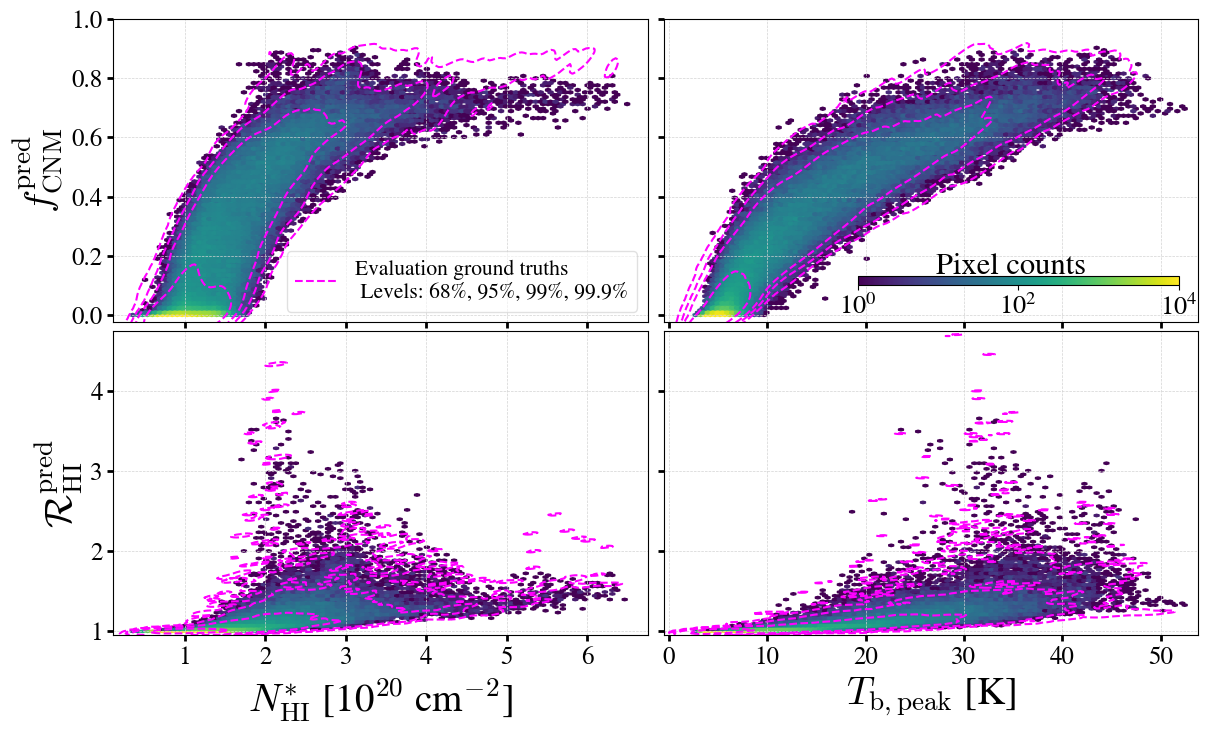

In [154]:
# Plot
xyfontsize = 28
npoints = 66_000
ctcolor = 'magenta'
ls = '--'
normalizer = LogNorm(1., 10000)


rows, cols = 2, 2
fig, ax = plt.subplots(rows, cols, sharex='col',  sharey='row', figsize=(14,8))


# axis 1
ax1 = ax[0, 0]
img = ax1.hexbin(NHI_thin_flat, Fcnm_flat, gridsize=100, cmap='viridis', norm=normalizer) # cividis


x,y = NHI_thin_flat, Fcnm_gt_flat
indices = np.random.choice(len(x), size=npoints, replace=False)
x,y = x[indices], y[indices]

tdata = {
    'x' : x.astype('float32'),
    'y' : y.astype('float32')
}

del x, y, indices
sns.kdeplot(data=tdata, x='x', y='y', ax=ax1, levels=[0.001, 0.01, 0.05, 0.32], linestyles=ls, color=ctcolor)

ploti, = ax1.plot([], [], ls=ls, color=ctcolor, label='Evaluation ground truths \n Levels: 68%, 95%, 99%, 99.9%')
ploti.set_visible(True)

ax1.set_ylabel(r'${f^\mathrm{pred}_\mathrm{CNM}}$', fontsize=xyfontsize, fontweight='normal')

ax1.set_ylim(-0.025, 1.)

ax1.tick_params(axis='x', labelsize=18, pad=4)
ax1.tick_params(axis='y', labelsize=18)
ax1.tick_params(which='both', width=2)
ax1.tick_params(which='major', length=4)
ax1.tick_params(which='minor', length=2)

ax1.grid(True, linestyle='--', linewidth=0.5, color='lightgray', zorder=-10)
ax1.legend(loc='lower right', fancybox=True, framealpha=0.6, labelcolor='k', fontsize=15.5)






# Axis 2
ax2 = ax[0, 1]

img = ax2.hexbin(tbmax_flat, Fcnm_flat, gridsize=100, cmap='viridis', norm=normalizer)

x,y = tbmax_flat, fcnm_data.flatten()
indices = np.random.choice(len(x), size=npoints, replace=False)
x,y = x[indices], y[indices]
tdata = {
    'x' : x.astype('float32'),
    'y' : y.astype('float32')
}
del x, y, indices
sns.kdeplot(data=tdata, x='x', y='y', ax=ax2, levels=[0.001, 0.01, 0.05, 0.32], linestyles=ls, color=ctcolor)


axins1 = inset_axes(ax2,
                    width="60%",
                    height="3.0%",
                    loc="lower right",
                    borderpad = 2,
                    bbox_to_anchor = (0.015,0.032,1,0.95),
                    bbox_transform=ax2.transAxes # axe here
                    )
axins1.xaxis.set_ticks_position("top")
cbar = fig.colorbar(img,
                    cax=axins1,
                    orientation='horizontal',
                    fraction=50,
                    pad=10., aspect=95)
cbar.ax.set_ylabel('Pixel counts', rotation=0, labelpad=-110., fontsize=22)
cbar.ax.tick_params(labelsize=19)





ax2.set_ylim(-0.025, 1.)

ax2.tick_params(axis='x', labelsize=18, pad=4)
ax2.tick_params(axis='y', labelsize=18)
ax2.tick_params(which='both', width=2)
ax2.tick_params(which='major', length=4)
ax2.tick_params(which='minor', length=2)

ax2.grid(True, linestyle='--', linewidth=0.5, color='lightgray', zorder=-10)




# Axis 3
ax3 = ax[1, 0]

img = ax3.hexbin(NHI_thin_flat, Rhi_flat, gridsize=100, cmap='viridis', norm=normalizer)

x,y = NHI_thin_flat, rhi_data_gt_flat
indices = np.random.choice(len(x), size=npoints, replace=False)
x,y = x[indices], y[indices]
tdata = {
    'x' : x.astype('float32'),
    'y' : y.astype('float32')
}
del x, y, indices
sns.kdeplot(data=tdata, x='x', y='y', ax=ax3, levels=[0.001, 0.01, 0.05, 0.32], linestyles=ls, color=ctcolor)



ax3.set_xlabel(r'$N^{*}_\mathrm{HI}$ [10$^{20}$ cm$^{-2}$]', fontsize=xyfontsize)
ax3.set_ylabel(r'${\mathcal{R}^\mathrm{pred}_\mathrm{HI}}$', fontsize=xyfontsize, fontweight='normal')

ax3.tick_params(axis='x', labelsize=18, pad=4)
ax3.tick_params(axis='y', labelsize=18)
ax3.tick_params(which='both', width=2)
ax3.tick_params(which='major', length=4)
ax3.tick_params(which='minor', length=2)

ax3.grid(True, linestyle='--', linewidth=0.5, color='lightgray', zorder=-10)







# Axis 4
ax4 = ax[1, 1]

img = ax4.hexbin(tbmax_flat, Rhi_flat, gridsize=100, cmap='viridis', norm=normalizer)

x,y = tbmax_flat, rhi_data_gt_flat
indices = np.random.choice(len(x), size=npoints, replace=False)
x,y = x[indices], y[indices]
tdata = {
    'x' : x.astype('float32'),
    'y' : y.astype('float32')
}
del x, y, indices
sns.kdeplot(data=tdata, x='x', y='y', ax=ax4, levels=[0.001, 0.01, 0.05, 0.32], linestyles=ls, color=ctcolor)


ax4.set_xlabel(r'$T_\mathrm{b,peak}$ [K]', fontsize=xyfontsize)

ax4.tick_params(axis='x', labelsize=18, pad=4)
ax4.tick_params(axis='y', labelsize=18)
ax4.tick_params(which='both', width=2)
ax4.tick_params(which='major', length=4)
ax4.tick_params(which='minor', length=2)

ax4.grid(True, linestyle='--', linewidth=0.5, color='lightgray', zorder=-10)


plt.subplots_adjust(left=None,
                    bottom=None,
                    right=None,
                    top=None,
                    wspace=0.03,
                    hspace=0.03
                    )

# fig.savefig('trends_pred.png', bbox_inches='tight')
plt.show()
plt.close()